# Predicting Airbnb Guest Experience from Past Guest Reviews

In [9]:
#importing useful libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

import re
import math

import nltk
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from gensim.models import word2vec
from langdetect import detect

from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, f1_score, accuracy_score, precision_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

from IPython.core.display import display, HTML
from IPython.display import Image
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
%matplotlib inline

import logging
import warnings; warnings.simplefilter('ignore')

**Import the reviews dataset**

In [3]:
reviews = pd.read_csv('~/Desktop/Projects/Airbnb/reviews.csv', sep=',')

In [4]:
reviews.comments[0]

'The room was just as described and everything clean and in place. There was even some tea and a nice welcome note upon my arrival. Little things like that make the difference. The location is great with easy bus lines to downtown. The Alamo park is a nice relaxing area and there are some good coffee shops in the around. Maryanna provided all the information I needed and regularly asked if there was anything else I could use to make my stay better. I recommend this stay for a great BnB experience in a unique Victorian-style home. '

**Import to the listings data**

In [105]:
listings = pd.read_csv('listings.csv', sep=',')

## Data Pre-Processing

In [95]:
listings = listings.rename(columns={'id': 'listing_id'})
listings = listings[['listing_id', 'review_scores_rating', 'number_of_reviews']]
listings = listings.drop(listings[listings.number_of_reviews < 5].index) #remove listings with less than 5 reviews
listings = listings.dropna(how='any')
listings = listings[['listing_id', 'review_scores_rating']]

listings.head()

,listing_id,review_scores_rating
0,16570521,95.0
4,15664146,92.0
5,1427660,98.0
6,19745324,97.0
8,69681,92.0


In [104]:
listings.review_scores_rating.describe()

count    5088.000000
mean       95.114976
std         4.855930
min        60.000000
25%        93.000000
50%        96.000000
75%        98.000000
max       100.000000
Name: review_scores_rating, dtype: float64

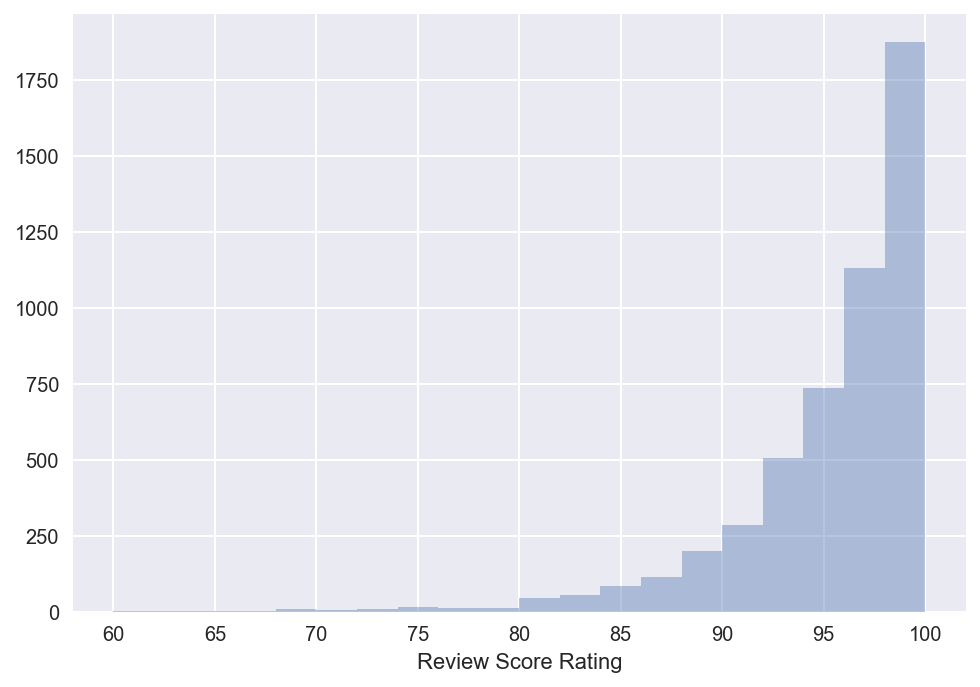

In [18]:
sns.distplot(listings.review_scores_rating, bins=20, kde=False, rug=False, axlabel='Review Score Rating');

We see that the majoritry 

**Merge the listings and reviews dataframes**

In [19]:
df = pd.merge(listings, reviews)
df = df[['listing_id', 'comments', 'review_scores_rating']]

In [20]:
df = df[df.comments.str.contains("The host canceled this reservation ") == False]
df = df[df.comments.str.contains("The reservation was canceled ") == False]

In [21]:
df = df.dropna(how='any')

In [22]:
df.head()

,listing_id,comments,review_scores_rating
0,16570521,Eugenia and Alessandro were incredibly warm an...,95.0
1,16570521,It was great staying at Eugenia's and Alessand...,95.0
2,16570521,Great place. Fantastic location. Hosts very he...,95.0
3,16570521,The place was great and comfortable in a very ...,95.0
4,16570521,Eugenia and Alessandro were very welcoming to ...,95.0


In [23]:
print('There are', df.shape[0], 'reviews in the dataset')

There are 249603 reviews in the dataset


In [24]:
df2 = df.head(100)

**Now that the dataset merged, we can start processing the text**

In [26]:
#remove non-English comments

In [29]:
df = df[(df.comments.str.len() > 20)]

In [30]:
print('There are', df.shape[0], 'reviews in the dataset')

There are 245853 reviews in the dataset


In [31]:
def find_language(x):
    try:
        return detect(x)
    except:
        return 'error'

In [32]:
df['language'] = df['comments'].apply(lambda x:find_language(x))

In [36]:
df = df.drop(df[df.language != 'en'].index)

In [37]:
df.shape

(232653, 4)

Now we have only English reviews

In [38]:
df = df.drop(['language'], axis =1)

In [39]:
df.head()

,listing_id,comments,review_scores_rating
0,16570521,Eugenia and Alessandro were incredibly warm an...,95.0
1,16570521,It was great staying at Eugenia's and Alessand...,95.0
2,16570521,Great place. Fantastic location. Hosts very he...,95.0
3,16570521,The place was great and comfortable in a very ...,95.0
4,16570521,Eugenia and Alessandro were very welcoming to ...,95.0


In [42]:
# Use regular expressions to find and replace
def review_to_wordlist(x, remove_stopwords=True): #stop word as optional
    x = str(x)
    
    wordnet_lemmatizer = WordNetLemmatizer()
    x = re.sub("[^a-zA-Z]", " ", x) #letters only    
    x = x.lower().split() #turn to lowercase and split into words

    if remove_stopwords:
        stops = set(stopwords.words("english")) # set is faster than list
        x = [wordnet_lemmatizer.lemmatize(word) for word in x if word not in stops]
    return " ".join(x)

df['comments'] = df['comments'].apply(review_to_wordlist)

In [43]:
sentences = df['comments'].tolist()

In [44]:
for l in range(0, len(sentences)):
    sentences[l] = sentences[l].split()

In [45]:
sentences[0]

['eugenia',
 'alessandro',
 'incredibly',
 'warm',
 'welcoming',
 'space',
 'impeccable',
 'great',
 'quality',
 'price',
 'ratio',
 'beautiful',
 'scenic',
 'neighborhood',
 'easy',
 'parking',
 'would',
 'highly',
 'recommend']

**create train/test split**

In [46]:
df = df[['comments', 'review_scores_rating']]

df = df.dropna(axis=0, how='any')

df.head()

,comments,review_scores_rating
0,eugenia alessandro incredibly warm welcoming s...,95.0
1,great staying eugenia alessandro beautiful lov...,95.0
2,great place fantastic location host helpful re...,95.0
3,place great comfortable pleasant quiet neighbo...,95.0
4,eugenia alessandro welcoming u basement basica...,95.0


In [151]:
X = df['comments']
y = df['review_scores_rating']

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
len(X_train), len(X_test), len(y_train), len(y_test)

(186122, 46531, 186122, 46531)

## Create word vectors

In [49]:
# Configure the logging module so that Word2Vec creates nice output messages

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

In [50]:
# Set values for various parameters
num_features = 50    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 20          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [51]:
# Initialize and train the model (this will take some time)
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)


2018-01-02 07:39:09,914 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2018-01-02 07:39:09,917 : INFO : collecting all words and their counts
2018-01-02 07:39:09,918 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-01-02 07:39:10,008 : INFO : PROGRESS: at sentence #10000, processed 328041 words, keeping 9507 word types
2018-01-02 07:39:10,090 : INFO : PROGRESS: at sentence #20000, processed 656099 words, keeping 13095 word types
2018-01-02 07:39:10,141 : INFO : PROGRESS: at sentence #30000, processed 931299 words, keeping 15698 word types
2018-01-02 07:39:10,200 : INFO : PROGRESS: at sentence #40000, processed 1250781 words, keeping 17779 word types
2018-01-02 07:39:10,268 : INFO : PROGRESS: at sentence #50000, processed 1579096 words, keeping 19978 word types
2018-01-02 07:39:10,336 : INFO : PROGRESS: at sentence #60000, processed 1897919 words, keeping 21862 word types
2018-01-02 07:39:10,399 : INFO : PROGRESS: at sen

Training model...


In [52]:
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

2018-01-02 07:39:48,374 : INFO : precomputing L2-norms of word weight vectors


**Now that the model is trained we can test it out**

In [53]:
print('The model has a vocabulary of', model.wv.syn0.shape[0],'words')

The model has a vocabulary of 5667 words


In [109]:
(model["guest"])

array([ 0.18460426, -0.05469021, -0.17595169, -0.24518524, -0.05278677,
       -0.03801234,  0.02173526, -0.09671655, -0.08303154,  0.02132847,
       -0.10080424, -0.03698028, -0.13247897, -0.03020025,  0.24013272,
        0.07796572, -0.19652875,  0.05560591,  0.02532151,  0.20867431,
       -0.14583357, -0.13906603, -0.19833033,  0.21320339,  0.22925778,
       -0.16669326, -0.1234057 ,  0.21458164,  0.13256392,  0.00463941,
        0.16893825, -0.29187137, -0.124005  , -0.09430454, -0.09248599,
        0.03063139,  0.01324844, -0.18619825,  0.00859407, -0.26272884,
        0.10283627, -0.08677934, -0.12431945, -0.0389857 ,  0.25183278,
        0.14710218, -0.01742067, -0.05386596, -0.08856376, -0.05978923], dtype=float32)

In [110]:
(model["guest"]).shape

(50,)

Each word is represented by a 1x50 numpy array 

Let's see if the word vectors make sense by examining similar words

In [55]:
model.most_similar("host")

[('hostess', 0.7447920441627502),
 ('communicator', 0.6245947480201721),
 ('extremely', 0.6012884378433228),
 ('nina', 0.5771051645278931),
 ('carlos', 0.5199190974235535),
 ('juan', 0.5196049213409424),
 ('michel', 0.5085746645927429),
 ('robert', 0.4986230731010437),
 ('location', 0.49570387601852417),
 ('incredibly', 0.4899801015853882)]

In [56]:
model.most_similar("clean")

[('spacious', 0.7565823197364807),
 ('neat', 0.7011836767196655),
 ('tidy', 0.6939375996589661),
 ('roomy', 0.6611204147338867),
 ('modern', 0.65269535779953),
 ('functional', 0.61244136095047),
 ('bed', 0.5866390466690063),
 ('cozy', 0.5742331147193909),
 ('sized', 0.5714325308799744),
 ('large', 0.5697606205940247)]

In [57]:
model.most_similar("dirty")

[('stain', 0.8899655342102051),
 ('dusty', 0.88738614320755),
 ('dust', 0.8773132562637329),
 ('disgusting', 0.8761452436447144),
 ('filthy', 0.8749378323554993),
 ('carpet', 0.854412853717804),
 ('dirt', 0.850810170173645),
 ('mold', 0.8504944443702698),
 ('cleaned', 0.8459546566009521),
 ('cleaner', 0.8441740274429321)]

In [58]:
model.doesnt_match("breakfast cereal dinner lunch".split())

'cereal'

In [153]:
model.doesnt_match("clean lovely bright filthy".split())

'filthy'

So far, it seems that the model has learned word embeddings, and is able to find similar or mismatching words appropriately. 

**Word clustering**

In [60]:
# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.wv.syn0
num_clusters = word_vectors.shape[0] / 5
num_clusters = math.floor(num_clusters)

In [61]:
word_vectors.shape[0]

5667

In [62]:
num_clusters

1133

In [63]:
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)

In [64]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip(model.wv.index2word, idx))

In [65]:
ls = list(word_centroid_map.values())
lk = list(word_centroid_map.keys())

In [66]:
# For the first 10 clusters
for cluster in range(0,10):
    
    # Print the cluster number  
    print("\nCluster %d" % cluster)

    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0,len(word_centroid_map.values())):
        if(ls[i] == cluster ):
            words.append(lk[i])
    print(words)


Cluster 0
['thoughtful', 'stocking']

Cluster 1
['lol', 'haha', 'gotta', 'sweat', 'ya']

Cluster 2
['touched', 'overwhelmed']

Cluster 3
['missing', 'properly', 'improvement', 'replaced', 'repair', 'fixing', 'adjust', 'sticky', 'threw', 'housekeeping', 'replace', 'replacement']

Cluster 4
['girl', 'purpose', 'school', 'college', 'student']

Cluster 5
['rose', 'joshua', 'felicia', 'gigi', 'ginger', 'kesinee', 'harvey', 'kp', 'm']

Cluster 6
['restaurant', 'food', 'eat', 'eatery', 'eats', 'resturants', 'restuarants']

Cluster 7
['district', 'inner', 'outer']

Cluster 8
['angie', 'silvia', 'constance', 'olga', 'freddi', 'gianmatteo', 'isabelle', 'uschi']

Cluster 9
['appear']


**We can see that the model can cluster different themes**

In [67]:
def create_bag_of_centroids(wordlist, word_centroid_map ):
    
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    # Return the "bag of centroids"
    return bag_of_centroids

In [68]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros( (len(X_train), num_clusters), dtype="float32" )

# Transform the training set reviews into bags of centroids
counter = 0
for review in X_train:
    train_centroids[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

# Repeat for test reviews 
test_centroids = np.zeros((len(X_test), num_clusters), dtype="float32")

counter = 0
for review in X_test:
    test_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1


**Let's consider a rating score above 96 (the median score) positive, and under 96 will be negative**

In [154]:
y_test[y_test < 96] = 0
y_test[y_test >= 96] = 1

In [155]:
y_train[y_train < 96] = 0
y_train[y_train >= 96] = 1

## Making predictions


**Gradient boosted trees** 

In [156]:
model_gb2 = GradientBoostingClassifier(n_estimators=200, max_features=None, max_depth=10)
model_gb2.fit(train_centroids, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [157]:
gb2_pred = model_gb2.predict(test_centroids)

In [158]:
np.mean(gb2_pred), np.mean(y_test)

(0.93269003460058886, 0.5936902280200297)

In [159]:
print('precision_score: %.2f' % precision_score(y_test, gb2_pred))
print('accuracy_score: %.2f' % accuracy_score(y_test, gb2_pred))
print('f1_score: %.2f' % f1_score(y_test, gb2_pred))

precision_score: 0.59
accuracy_score: 0.58
f1_score: 0.73




**Random Forests**

In [89]:
model_rf9 = RandomForestClassifier(n_estimators=150, max_features=None, max_depth=10)
model_rf9.fit(train_centroids, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
rf9_pred = model_rf9.predict(test_centroids)

In [92]:
print('precision_score: %.2f' % precision_score(y_test, rf9_pred))
print('accuracy_score: %.2f' % accuracy_score(y_test, rf9_pred))
print('f1_score: %.2f' % f1_score(y_test, rf9_pred))

precision_score: 0.70
accuracy_score: 0.70
f1_score: 0.82


## Summary and Conclusions


In this analysis, we've cleaned and analyzed Airbnb reviews in order to predict future guest experience.  
We've used word vectors and a clustering approach to create clusters of semantically related words.
We then used random forests and boosted trees to classify each review as positive or negative based off of a listings ratings (supervised learning).

Based on mediocore f1 score results from these two approaches, we can conclude that perhaps more features besides the reviews should be employed to predict ratings. After all, guests' reports are public, and perhaps don't accurately represent the numerical ratings they provided after their experience. 

Furthermore, more advanced deep learning approaches, such as recurrent neural networks, which perserve word order can be employed to extract further meaning from each review. Finally, a larger dataset could be examined, as this set contained only approximately 5000 listings. 